### Importações e variáveis globais

#### Libs

In [333]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from functools import reduce
import re

In [369]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

matplotlib.rcParams['figure.figsize'] = 16,8
plt.rcParams['axes.axisbelow'] = True

#### Globais

In [335]:
global epw_columns, snames_inhf, snames_outhf, snames_tout, snames_tin, snames_hs, climas_def
global mes, meses, casos, area, freq, zonas, eixoy, inic

surfaces_names = ('PERIMETER_TOP_PLENUM_WALL_NORTH','PERIMETER_TOP_PLENUM_WALL_EAST',
'PERIMETER_TOP_PLENUM_WALL_SOUTH','PERIMETER_TOP_PLENUM_WALL_WEST','BUILDING_ROOF',
'PERIMETER_MID_PLENUM_WALL_NORTH','PERIMETER_MID_PLENUM_WALL_EAST','PERIMETER_MID_PLENUM_WALL_SOUTH',
'PERIMETER_MID_PLENUM_WALL_WEST','PERIMETER_BOT_PLENUM_WALL_NORTH','PERIMETER_BOT_PLENUM_WALL_EAST',
'PERIMETER_BOT_PLENUM_WALL_SOUTH','PERIMETER_BOT_PLENUM_WALL_WEST','PERIMETER_TOP_ZN_3_WALL_NORTH',
'PERIMETER_TOP_ZN_2_WALL_EAST','PERIMETER_TOP_ZN_1_WALL_SOUTH','PERIMETER_TOP_ZN_4_WALL_WEST',
'PERIMETER_BOT_ZN_3_WALL_NORTH','PERIMETER_BOT_ZN_2_WALL_EAST','PERIMETER_BOT_ZN_1_WALL_SOUTH',
'PERIMETER_BOT_ZN_4_WALL_WEST','PERIMETER_MID_ZN_3_WALL_NORTH', 'PERIMETER_MID_ZN_2_WALL_EAST',
'PERIMETER_MID_ZN_1_WALL_SOUTH','PERIMETER_MID_ZN_4_WALL_WEST')

epw_columns = ('Year','Month','Day','Hour','Minute','Source',
'DBT [°C]','DPT [°C]','RU [%]','AtmPa [Pa]','ETGlbHrz [Wh/m²]', 'ETdirNrm [Wh/m²]', 
'InfraRed [Wh/m²]', 'GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'DifHrz [Wh/m²]',
'LuxGlbHrz [lux]', 'LuxDirNrm [lux]', 'LuxDifHrz [lux]', 'LuxZenit [lux]', 
'DirWind [°]', 'DirSpeed [m/s]', 'Nebul', 'Opac', 'Visib [km]', 'Height [m]', 'Obs', 'Code',
'Precp [mm]', 'Aerosol', 'SnowDepth [cm]', 'SinceSnow', 'Albedo ', 'PrecDep [mm]', 'PrepTax [h]')

#snames_hf = []
snames_hs = []
snames_tin = []
snames_tout = []
snames_inhf = []
snames_outhf = []

for item in surfaces_names:
    #snames_hf.append(item + ':Surface Average Face Conduction Heat Transfer Rate per Area [W/m2](Hourly)')
    snames_hs.append(item + ':Surface Heat Storage Rate per Area [W/m2](Hourly)')
    snames_tin.append(item + ':Surface Inside Face Temperature [C](Hourly)')
    snames_tout.append(item + ':Surface Outside Face Temperature [C](Hourly)')
    snames_inhf.append(item + ':Surface Inside Face Conduction Heat Transfer Rate per Area [W/m2](Hourly)')
    snames_outhf.append(item + ':Surface Outside Face Conduction Heat Transfer Rate per Area [W/m2](Hourly)')

#snames_hf = tuple(snames_hf)
#snames_hs = tuple(snames_hs)
snames_tin = tuple(snames_tin)
snames_tout = tuple(snames_tout)
snames_inhf = tuple(snames_inhf)
snames_outhf = tuple(snames_outhf)

mes = ('Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez')

inic = [x[0] for x in mes]

meses = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun', 
        7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'}

casos = {'ISO': 'Isolante Térmico Resistivo', 'PCM': 'Material de Mudança de Fase', 'VAZ': 'Nenhum Material'}

freq = {'H': 'Horária', 'D': 'Diária', 'W': 'Semanal', 'M': 'Mensal', 'Y': 'Anual'}

zonas = {'MID_ZN_1': 'Zona Térmica 1 (Fachada Sul)', 'MID_ZN_3': 'Zona Térmica 3 (Fachada Norte)', 'TOP': 'Plenum'}

climas_def = {'2021':'TMYx', '2051':'Projeção 2050', '2081':'Projeção 2080'}

area = 4982.19 # m²

### Funções e classes

#### Funções

In [370]:
def renomear(name):
    def corte(name):
        s = re.split(r'[:_]',name)
        return s[-2]

    if 'Inside Face Conduction' in name:
        return (f'Fluxo de calor por condução face interna [W/m²]')
    elif 'Outside Face Conduction' in name:
        return (f'Fluxo de calor por condução face externa [W/m²]')
    elif 'Storage' in name:
        return (f'Taxa de calor armazenado na superfície [W/m²]')
    elif 'Inside Face Temperature' in name:
        return (f'Temperatura da face interna [°C]')
    elif 'Outside Face Temperature' in name:
        return (f'Temperatura da face externa [°C]')
    elif 'Radiant' in name:
        return 'Temperatura Média Radiante [°C]'
    elif 'Operative' in name:
        return 'Temperatura Operativa [°C]'


def dicionario(df_list):
    """
    Cria um dicionário de dataframes com os anos como chave.
    """

    df_dict = {}
    for key, df in enumerate(df_list):
        year = df.index.year[0]
        df_dict[key] = df
        df_dict[year] = df_dict.pop(key)

    return df_dict


def comparar_climas(climate_list):
    dummy = climate_list.copy()
    df = pd.DataFrame()
    medias = {}
    extremos = {}

    for climate in dummy:
        climate[0].index = pd.date_range(start=f'1/1/2000', periods=len(climate[0]), freq='M')
        df[climas_def[str(int(climate[1])+1)]] = climate[0]
        medias[climas_def[str(int(climate[1])+1)]] = climate[0].mean()
        extremos[climas_def[str(int(climate[1])+1)]] = [climate[2][0], climate[2][1]]

    df['Mês'] = df.index.month
    df['Mês'] = df['Mês'].map(meses)

    df.plot(x = 'Mês', title = f'Temperatura de Bulbo Seco Externa - Média Mensal',
            figsize=(16,8), ylabel = 'Temperatura [°C]', grid='both', marker = 'o')
    plt.xticks(np.arange(12), labels = mes);

    print('Média Anual')
    for key, value in medias.items():
        if key == 'TMYx':
            print(f'{key}: {round(value,2)} °C') 
        else:
            var = -100*(medias['TMYx'] - medias[key])/medias['TMYx']
            print(f'{key}: {round(value,2)} °C (+{round(var,2)} %)')
    
    print('\nMínima Anual')
    for key, value in extremos.items():
        if key == 'TMYx':
            print(f'{key}: {round(value[0],2)} °C') 
        else:
            var = -100*(extremos['TMYx'][0] - extremos[key][0])/extremos['TMYx'][0]
            print(f'{key}: {round(value[0],2)} °C (+{round(var,2)} %)')
    
    print('\nMáxima Anual')
    for key, value in extremos.items():
        if key == 'TMYx':
            print(f'{key}: {round(value[1],2)} °C') 
        else:
            var = -100*(extremos['TMYx'][1] - extremos[key][1])/extremos['TMYx'][1]
            print(f'{key}: {round(value[1],2)} °C (+{round(var,2)} %)')

    return df, medias


def comparar_anos(zone_list, var, resample=False, how=None):
    """
    Cria um dicionário com os parâmetros que deseja-se comparar entre as aplicações nos mesmos anos. 
    """

    dummy = zone_list.copy()
    df = pd.DataFrame()

    for zone in dummy:
        zone[0][var].index = pd.date_range(start=f'1/1/2000', periods=len(zone[0][var]), freq='H')
        df[zone[1][2]] = zone[0][var]

    if resample != None and how != None:
        df.resample(how).mean().plot(title = f'{zonas[dummy[0][2]]} - {var}\nZona Climática {dummy[0][1][0]}',
                                     figsize=(16,8), ylabel = f'{var} - Média {freq[how]}', grid='both')
    else:
        df.plot(title = f'{zonas[dummy[0][2]]} - {var}Zona Climática {dummy[0][1][0]}', 
                figsize=(16,8), ylabel = var, grid='both')

    return df


def comparar_casos(zone_list, var1, var2=None, resample = False, how = None, trunc = False, before = None, after = None):
    """
    Cria um dicionário com os parâmetros que deseja-se comparar entre as aplicações nos mesmos anos. 
    """

    dummy = zone_list.copy()
    df1 = pd.DataFrame()
    df2 = pd.DataFrame()

    print(f'Opções: {list(dummy[0][0].columns)}')

    for zone in dummy:
        df1[casos[zone[1][1]]] = zone[0][var1]
    
    if trunc != False and before != None and after != None:
        df1 = df1.truncate(before = before, after = after)
    else:
        pass

    if resample != None and how != 'M':
        df1.resample(how).mean().plot(title = f'{zonas[dummy[0][2]]} - {var1}\nZona Climática {dummy[0][1][0]} - Ano referência {dummy[0][1][-1]}',
                                        figsize=(14,7), ylabel = f'{var1} - Média {freq[how]}', grid='both')
        
    elif resample != None and how == 'M' and var1.startswith('Fluxo'):
        df1.resample(how).sum().plot.bar(title = f'{zonas[dummy[0][2]]} - {var1}\nZona Climática {dummy[0][1][0]} - Ano referência {dummy[0][1][-1]}',
                                        figsize=(14,7), ylabel = f'{var1}', grid='both', rot = 0)
        plt.xticks(range(12), mes);
    
    else:
        df1.plot(title = f'{zonas[dummy[0][2]]} - {var1}\nZona Climática {dummy[0][1][0]} - Ano referência {dummy[0][1][-1]}',
                figsize=(14,7), ylabel = var1, grid='both')
        
    if var2 != None:
        for zone in dummy:
            df1[casos[zone[1][1]]] = zone[0][var1]
        
        if trunc != False and before != None and after != None:
            df = df.truncate(before = before, after = after)
            difs = difs.truncate(before = before, after = after)
        else:
            pass

        if resample != None and how != None:
            df.resample(how).median().plot(title = f'{zonas[dummy[0][2]]} - {var1}\nZona Climática {dummy[0][1][0]} - Ano referência {dummy[0][1][-1]}',
                                            figsize=(16,8), ylabel = f'{var1} - Média {freq[how]}', grid='both')
        else:
            df.plot(title = f'{zonas[dummy[0][2]]} - {var1}\nZona Climática {dummy[0][1][0]} - Ano referência {dummy[0][1][-1]}',
                    figsize=(16,8), ylabel = var1, grid='both')      

    return df1


def comparar_consumo(consumos): 
    dummy = consumos.copy()

    df_aux = pd.DataFrame()
    tedi_2020 = {'Anos':[], 'Casos':[], 'Resfriamento [kWh]':[], 'Aquecimento [kWh]':[]}
    tedi_2050 = {'Anos':[], 'Casos':[], 'Resfriamento [kWh]':[], 'Aquecimento [kWh]':[]}
    tedi_2080 = {'Anos':[], 'Casos':[], 'Resfriamento [kWh]':[], 'Aquecimento [kWh]':[]}

    dfs = {2020: df_aux.copy(), 2050: df_aux.copy(), 2080: df_aux.copy()}
    dfd = {2020: df_aux.copy(), 2050: df_aux.copy(), 2080: df_aux.copy()}
    dfp = {2020: df_aux.copy(), 2050: df_aux.copy(), 2080: df_aux.copy()}
    dfr = {2020: tedi_2020, 2050: tedi_2050, 2080: tedi_2080}

    for consumo in dummy:
        dfs[int(consumo[1][2])][casos[consumo[1][1]]] = consumo[0]['Energia Elétrica [kWh]']
        dfd[int(consumo[1][2])][casos[consumo[1][1]]] = consumo[0]['Demanda [kW]']

        dfr[int(consumo[1][2])]['Anos'].append(int(consumo[1][2]))
        dfr[int(consumo[1][2])]['Casos'].append(casos[consumo[1][1]])
        dfr[int(consumo[1][2])]['Resfriamento [kWh]'].append(consumo[2]['Carga térmica de resfriamento [kWh]'].sum()/area)
        dfr[int(consumo[1][2])]['Aquecimento [kWh]'].append((consumo[2]['Carga térmica de aquecimento [kWh]']+consumo[2]['Carga térmica sensível de aquecimento [kWh]']).sum()/area)

    for key in dfr.keys():
        dfr[key] = pd.DataFrame(dfr[key])
        dfr[key] = dfr[key].reset_index(drop = True)
        dfr[key] = dfr[key].set_index(['Anos', 'Casos'])
    
    #------------------------------------------------------------------------------------------------------------
    # Consumo

    print('Economia de Energia Anual Média') 

    fig, axs = plt.subplots(1,3)
    aux = 0

    for key,df in dfs.items():

        df['Mês'] = df.index.month
        df['Mês'] = df['Mês'].map(meses)

        dfp[key]['Isolante Térmico Resistivo'] = (df['Nenhum Material'] - df['Isolante Térmico Resistivo'])*100/df['Nenhum Material']
        dfp[key]['Material de Mudança de Fase'] = (df['Nenhum Material'] - df['Material de Mudança de Fase'])*100/df['Nenhum Material']
        dfp[key]['Mês'] = dfp[key].index.month
        dfp[key]['Mês'] = dfp[key]['Mês'].map(meses)
        print(f'{key}: ISO {round(dfp[key][casos["ISO"]].mean(axis=0),2)}% | PCM {round(dfp[key][casos["PCM"]].mean(axis=0),2)}%')

        df.plot(x='Mês', title = f'{climas_def[str(key+1)]}', grid = 'both', ax = axs[aux], legend = False);
        axs[aux].set_xticks(range(12));
        axs[aux].set_xticklabels(inic);

        axs[aux].set_yticks(np.arange(5000, 42500, 2500))
        aux += 1

    plt.subplots_adjust(hspace=0.5, wspace=0.25)
    fig.supylabel(x = 0.07, t = 'Energia [kWh]')
    fig.suptitle(t = 'Energia Consumida para Climatização', va = 'center', fontsize=25)
    fig.legend(casos.values(), loc='lower center', ncol=len(casos.values()), 
               bbox_to_anchor=(0.5,-0.05), fontsize=20, frameon=False);
    fig.set_figheight(7)
    fig.set_figwidth(21)


    #------------------------------------------------------------------------------------------------------------
    ## Demanda

    print('\nRedução de Demanda Anual Média') 

    fig2, axs2 = plt.subplots(1,3)
    aux2 = 0

    for key, df in dfd.items():
        df['Mês'] = df.index.month
        df['Mês'] = df['Mês'].map(meses)

        dfp[key]['Isolante Térmico Resistivo'] = (df['Nenhum Material'] - df['Isolante Térmico Resistivo'])*100/df['Nenhum Material']
        dfp[key]['Material de Mudança de Fase'] = (df['Nenhum Material'] - df['Material de Mudança de Fase'])*100/df['Nenhum Material']
        dfp[key]['Mês'] = dfp[key].index.month
        dfp[key]['Mês'] = dfp[key]['Mês'].map(meses)
        print(f'{key}: ISO {round(dfp[key][casos["ISO"]].mean(axis=0),2)}% | PCM {round(dfp[key][casos["PCM"]].mean(axis=0),2)}%')

        df.plot(x='Mês', title = f'{climas_def[str(key+1)]}',grid = 'both', ax = axs2[aux2], legend = False);
        axs2[aux2].set_xticks(range(12));
        axs2[aux2].set_xticklabels(inic);

        axs2[aux2].set_yticks(np.arange(20, 160, 10))
        aux2 += 1

   
    plt.subplots_adjust(hspace=0.5, wspace=0.25)
    fig2.supylabel(x = 0.085, t = 'Demanda [kW]')
    fig2.suptitle(t = 'Demanda de Energia para Climatização', va = 'center', fontsize=25)
    fig2.legend(casos.values(), loc='lower center', ncol=len(casos.values()), 
                bbox_to_anchor=(0.5,-0.05), fontsize=20, frameon=False);
    fig2.set_figheight(7)
    fig2.set_figwidth(21)

    
    #------------------------------------------------------------------------------------------------------------
    # TEDI

    fig3, axs3 = plt.subplots(1,3)
    aux3 = 0

    for key, df in dfr.items():
        df.plot.bar(title = f'{climas_def[str(key+1)]}', grid = 'both', ax = axs3[aux3], 
                    legend = False, stacked = True, xlabel = None, rot = 0, color = ['royalblue', 'lightcoral']);
        axs3[aux3].set_yticks(np.arange(0, 240, 20))
        axs3[aux3].set_xticklabels(['Isolante', 'PCM', 'Nenhum\nMaterial'])
        axs3[aux3].set_xlabel(None)
        axs3[aux3].tick_params(bottom = False)
        aux3 += 1

    #plt.subplots_adjust(hspace=0.5, wspace=0.25)
    fig3.supylabel(x = 0.085, t = 'TEDI [kWh/m².ano]')
    fig3.suptitle(t = 'Thermal Energy Demand Intensity (TEDI)', va = 'center', fontsize=25)
    fig3.legend(['Cooling', 'Heating'], loc='lower center', ncol=len(casos.values()), 
                bbox_to_anchor=(0.5,-0.05), fontsize=20, frameon=False);
    fig3.set_figheight(7)
    fig3.set_figwidth(21)

    return dfr


def plotar_zona(zona_termica):
    """
    Plot de um dataframe com várias colunas ou apenas uma das colunas de interesse.
    """
    axes = zona_termica[0].resample('D').mean().plot(figsize=(15,30), subplots=True, legend = False, grid='both');
    plt.subplots_adjust(hspace=0.35)
    print("-".join(zona_termica[1]))

    for plots in axes:
        plots.set_title(zona_termica[0].columns[list(axes).index(plots)]);

    

#### Classe

In [337]:
class database:
    """
    Classe para base de dados dos resultados das simulações.
    """
    def __init__(self, path):
        df = pd.read_csv(path, sep = ',')

        def splitar(name, pos):
            s = name.split('/')
            s0 = re.split(r'[-.]',s[-1])
            return s0[pos]

        clzone = splitar(path, 0)
        case = splitar(path, 1)
        year = splitar(path, 2)

        self.app = (clzone, case, year)

        ## Modifica a coluna de índice
        df = df.drop(columns = ['Date/Time'])
        df.index = pd.date_range(start=f'1/1/{int(self.app[-1])+1}', periods=len(df), freq='H')
        df.index.name = 'Date/Time'

        self.df = df.copy()

        ## Cria subdataframes de acordo com as propriedades de interesse

        # Temperatura de bulbo seco do exterior
        self.dbt = df.copy().loc[:,'Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)']
        
        # Fluxo de calor por condução na superfície
        self.heat_flux_in = df.copy().loc[:, 
            df.columns.str.endswith('Surface Inside Face Conduction Heat Transfer Rate per Area [W/m2](Hourly)')]
        self.heat_flux_in = self.heat_flux_in[[col for col in self.heat_flux_in.columns if col in snames_inhf]]

        self.heat_flux_out = df.copy().loc[:, 
            df.columns.str.endswith('Surface Outside Face Conduction Heat Transfer Rate per Area [W/m2](Hourly)')]
        self.heat_flux_out = self.heat_flux_out[[col for col in self.heat_flux_out.columns if col in snames_outhf]]*(-1)

        self.heat_stg = df.copy().loc[:, 
            df.columns.str.endswith('Surface Heat Storage Rate per Area [W/m2](Hourly)')]
        self.heat_stg = self.heat_stg[[col for col in self.heat_stg.columns if col in snames_hs]]

        # Temperatura da face interna
        self.sur_ins = df.copy().loc[:, 
            df.columns.str.endswith('Surface Inside Face Temperature [C](Hourly)')]
        self.sur_ins = self.sur_ins[[col for col in self.sur_ins.columns if col in snames_tin]]

        # Temperatura da face externa
        self.sur_out = df.copy().loc[:, 
            df.columns.str.endswith('Surface Outside Face Temperature [C](Hourly)')]
        self.sur_out = self.sur_out[[col for col in self.sur_out.columns if col in snames_tout]]

        # Temperatura Média Radiante da Zona
        self.mrt = df.copy().loc[:, 
            df.columns.str.endswith('Zone Mean Radiant Temperature [C](Hourly)')]
        
        # Temperatura Operativa
        self.top = df.copy().loc[:, 
            df.columns.str.endswith('Zone Operative Temperature [C](Hourly)')]
       
        data_frames = [self.dbt, self.heat_flux_in, self.heat_flux_out, self.heat_stg,
                        self.sur_ins, self.sur_out, self.mrt, self.top]

        self.df_filter = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), data_frames)


    def clima(self):
        """
        Gera um dataframe com as médias mensais da temperatura de bulbo seco.
        """
        extremos = [self.dbt.min(), self.dbt.max()]
        df = self.dbt.copy().resample('M').mean()

        return df, self.app[-1], extremos


    def zone(self, zona_termica):
        """
        Extrai os outputs de uma zona térmica específica.
        """
        if zona_termica in ('TOP', 'MID', 'BOT'):
            df1 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.contains(zona_termica+'_PLENUM'))]
            df2 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.contains(zona_termica+'FLOOR'))]
            df3 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.startswith('BUILDING_ROOF'))]
            df4 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.contains('FIRSTFLOOR'))]

            if zona_termica == 'TOP':
                df = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), [df1,df2,df3])
            elif zona_termica == 'MID':
                df = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), [df1,df2])
            elif zona_termica == 'BOT':
                df = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), [df1,df4])
                                            
        else:
            df = self.df_filter.copy().loc[:, 
                self.df_filter.columns.str.contains(zona_termica)]
    
        df.columns = map(renomear, df.columns)
        df['Fluxo de calor líquido por condução [W/m²]'] = (df['Fluxo de calor por condução face interna [W/m²]'] + \
                                               df['Fluxo de calor por condução face externa [W/m²]'] - \
                                               df['Taxa de calor armazenado na superfície [W/m²]'])

        return df, self.app, zona_termica


    def hvac(self):
       
        df_cons = (self.df.copy().loc[:, 
           self.df.columns.str.startswith("Electricity")])/(3600E3)
        df_cons.columns = ["Energia Elétrica [kWh]"]
        df_cons = df_cons.resample('M').sum()

        df_dem = (self.df.copy().loc[:, 
           self.df.columns.str.contains("Demand")])/(1E3)
        df_dem.columns = ["Demanda [kW]"]
        df_dem = df_dem.resample('M').max()

        df = pd.concat([df_cons, df_dem], axis  = 1)

        df_load = (self.df.copy().loc[:, 
           self.df.columns.str.contains("EnergyTransfer")])/(3600E3)
        df_load = df_load.resample('M').sum()
        df_load.columns = ["Carga térmica sensível de aquecimento [kWh]",
                           "Carga térmica sensível de resfriamento [kWh]",
                           "Carga térmica de aquecimento [kWh]",
                           "Carga térmica de resfriamento [kWh]"]

        return df, self.app, df_load


class climate:
    def __init__(self, file, year):
        self.df_epw = pd.read_csv(file, names=epw_columns)
        self.df_epw = self.df_epw.drop(columns = ['Year','Month','Day','Hour','Minute'])
        self.df_epw.index = pd.date_range(start=f'1/1/{str(year)}', periods=len(self.df_epw), freq='H')

        self.df = self.df_epw.drop(columns=['Source','RU [%]','AtmPa [Pa]','ETGlbHrz [Wh/m²]', 'ETdirNrm [Wh/m²]', 
        'LuxGlbHrz [lux]', 'LuxDirNrm [lux]', 'LuxDifHrz [lux]', 'LuxZenit [lux]', 'DirWind [°]',
        'DirSpeed [m/s]', 'Nebul', 'Opac', 'Visib [km]', 'Height [m]', 'Obs', 'Code',
        'Precp [mm]', 'Aerosol', 'SnowDepth [cm]', 'SinceSnow', 'Albedo ', 'PrecDep [mm]', 'PrepTax [h]'])



### Execução

#### 2A

##### Lendo csv

In [338]:
zona_clima = '2A'

if zona_clima == '2A':
    pcm_2020 = database('outputs/2A/TMYx/2A-PCM-2020.csv')
    pcm_2050 = database('outputs/2A/TMYx/2A-PCM-2050.csv')
    pcm_2080 = database('outputs/2A/TMYx/2A-PCM-2080.csv')

    iso_2020 = database('outputs/2A/TMYx/2A-ISO-2020.csv')
    iso_2050 = database('outputs/2A/TMYx/2A-ISO-2050.csv')
    iso_2080 = database('outputs/2A/TMYx/2A-ISO-2080.csv')

    vaz_2020 = database('outputs/2A/TMYx/2A-VAZ-2020.csv')
    vaz_2050 = database('outputs/2A/TMYx/2A-VAZ-2050.csv')
    vaz_2080 = database('outputs/2A/TMYx/2A-VAZ-2080.csv')

elif zona_clima == '3A':
    pcm_2020 = database('outputs/3A/3A-PCM-2020.csv')
    pcm_2050 = database('outputs/3A/3A-PCM-2050.csv')
    pcm_2080 = database('outputs/3A/3A-PCM-2080.csv')

    iso_2020 = database('outputs/3A/3A-ISO-2020.csv')
    iso_2050 = database('outputs/3A/3A-ISO-2050.csv')
    iso_2080 = database('outputs/3A/3A-ISO-2080.csv')

    vaz_2020 = database('outputs/3A/3A-VAZ-2020.csv')
    vaz_2050 = database('outputs/3A/3A-VAZ-2050.csv')
    vaz_2080 = database('outputs/3A/3A-VAZ-2080.csv')

In [339]:
climas = [iso_2020.clima(),
          iso_2050.clima(),
          iso_2080.clima()]

consumos = [iso_2020.hvac(),
            iso_2050.hvac(),
            iso_2080.hvac(),
            
            pcm_2020.hvac(),
            pcm_2050.hvac(),
            pcm_2080.hvac(),
            
            vaz_2020.hvac(),
            vaz_2050.hvac(),
            vaz_2080.hvac()]

In [340]:
zn3_pcm2020 = pcm_2020.zone('MID_ZN_3')
zn3_pcm2050 = pcm_2050.zone('MID_ZN_3')
zn3_pcm2080 = pcm_2080.zone('MID_ZN_3')

zn1_pcm2020 = pcm_2020.zone('MID_ZN_1')
zn1_pcm2050 = pcm_2050.zone('MID_ZN_1')
zn1_pcm2080 = pcm_2080.zone('MID_ZN_1')

zn3_iso2020 = iso_2020.zone('MID_ZN_3')
zn3_iso2050 = iso_2050.zone('MID_ZN_3')
zn3_iso2080 = iso_2080.zone('MID_ZN_3')

zn1_iso2020 = iso_2020.zone('MID_ZN_1')
zn1_iso2050 = iso_2050.zone('MID_ZN_1')
zn1_iso2080 = iso_2080.zone('MID_ZN_1')

zn3_vaz2020 = vaz_2020.zone('MID_ZN_3')
zn3_vaz2050 = vaz_2050.zone('MID_ZN_3')
zn3_vaz2080 = vaz_2080.zone('MID_ZN_3')

zn1_vaz2020 = vaz_2020.zone('MID_ZN_1')
zn1_vaz2050 = vaz_2050.zone('MID_ZN_1')
zn1_vaz2080 = vaz_2080.zone('MID_ZN_1')

plenum_pcm2020 = pcm_2020.zone('TOP')
plenum_iso2020 = iso_2020.zone('TOP')
plenum_vaz2020 = vaz_2020.zone('TOP')

plenum_pcm2050 = pcm_2050.zone('TOP')
plenum_iso2050 = iso_2050.zone('TOP')
plenum_vaz2050 = vaz_2050.zone('TOP')

plenum_pcm2080 = pcm_2080.zone('TOP')
plenum_iso2080 = iso_2080.zone('TOP')
plenum_vaz2080 = vaz_2080.zone('TOP')


zn3_2020 = [zn3_iso2020, zn3_pcm2020, zn3_vaz2020]
zn3_2050 = [zn3_iso2050, zn3_pcm2050, zn3_vaz2050]
zn3_2080 = [zn3_iso2080, zn3_pcm2080, zn3_vaz2080]

zn1_2020 = [zn1_iso2020, zn1_pcm2020, zn1_vaz2020]
zn1_2050 = [zn1_iso2050, zn1_pcm2050, zn1_vaz2050]
zn1_2080 = [zn1_iso2080, zn1_pcm2080, zn1_vaz2080]

plenum_2020 = [plenum_iso2020, plenum_pcm2020, plenum_vaz2020]
plenum_2050 = [plenum_iso2050, plenum_pcm2050, plenum_vaz2050]
plenum_2080 = [plenum_iso2080, plenum_pcm2080, plenum_vaz2080]

Economia de Energia Anual Média
2020: ISO 32.23% | PCM 37.77%
2050: ISO 28.59% | PCM 36.43%
2080: ISO 29.03% | PCM 33.9%

Redução de Demanda Anual Média
2020: ISO 45.08% | PCM 53.55%
2050: ISO 36.02% | PCM 46.67%
2080: ISO 34.91% | PCM 42.1%


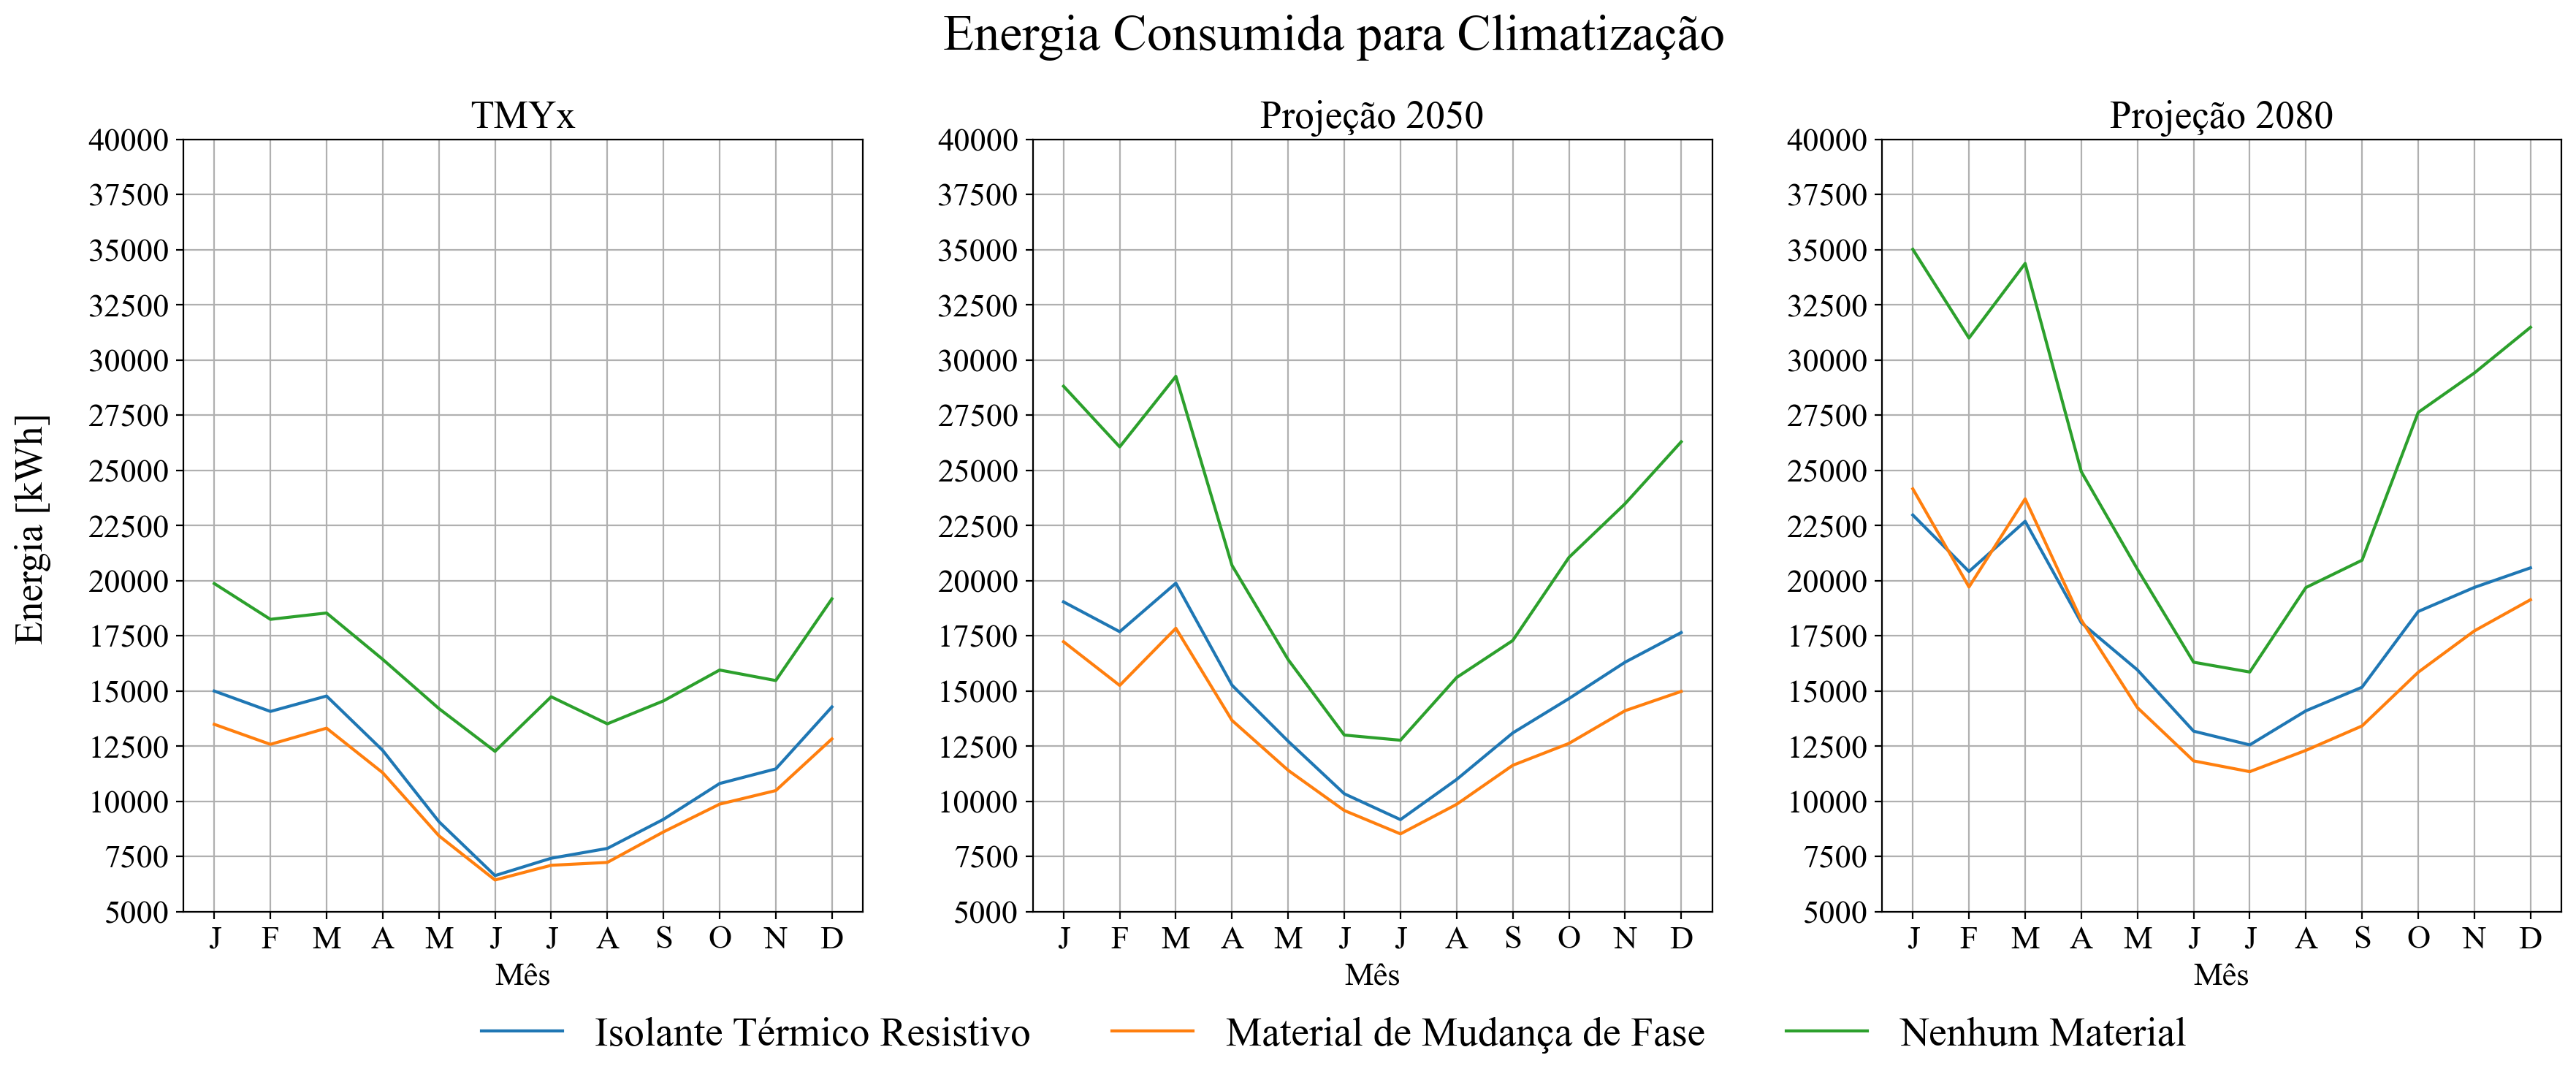

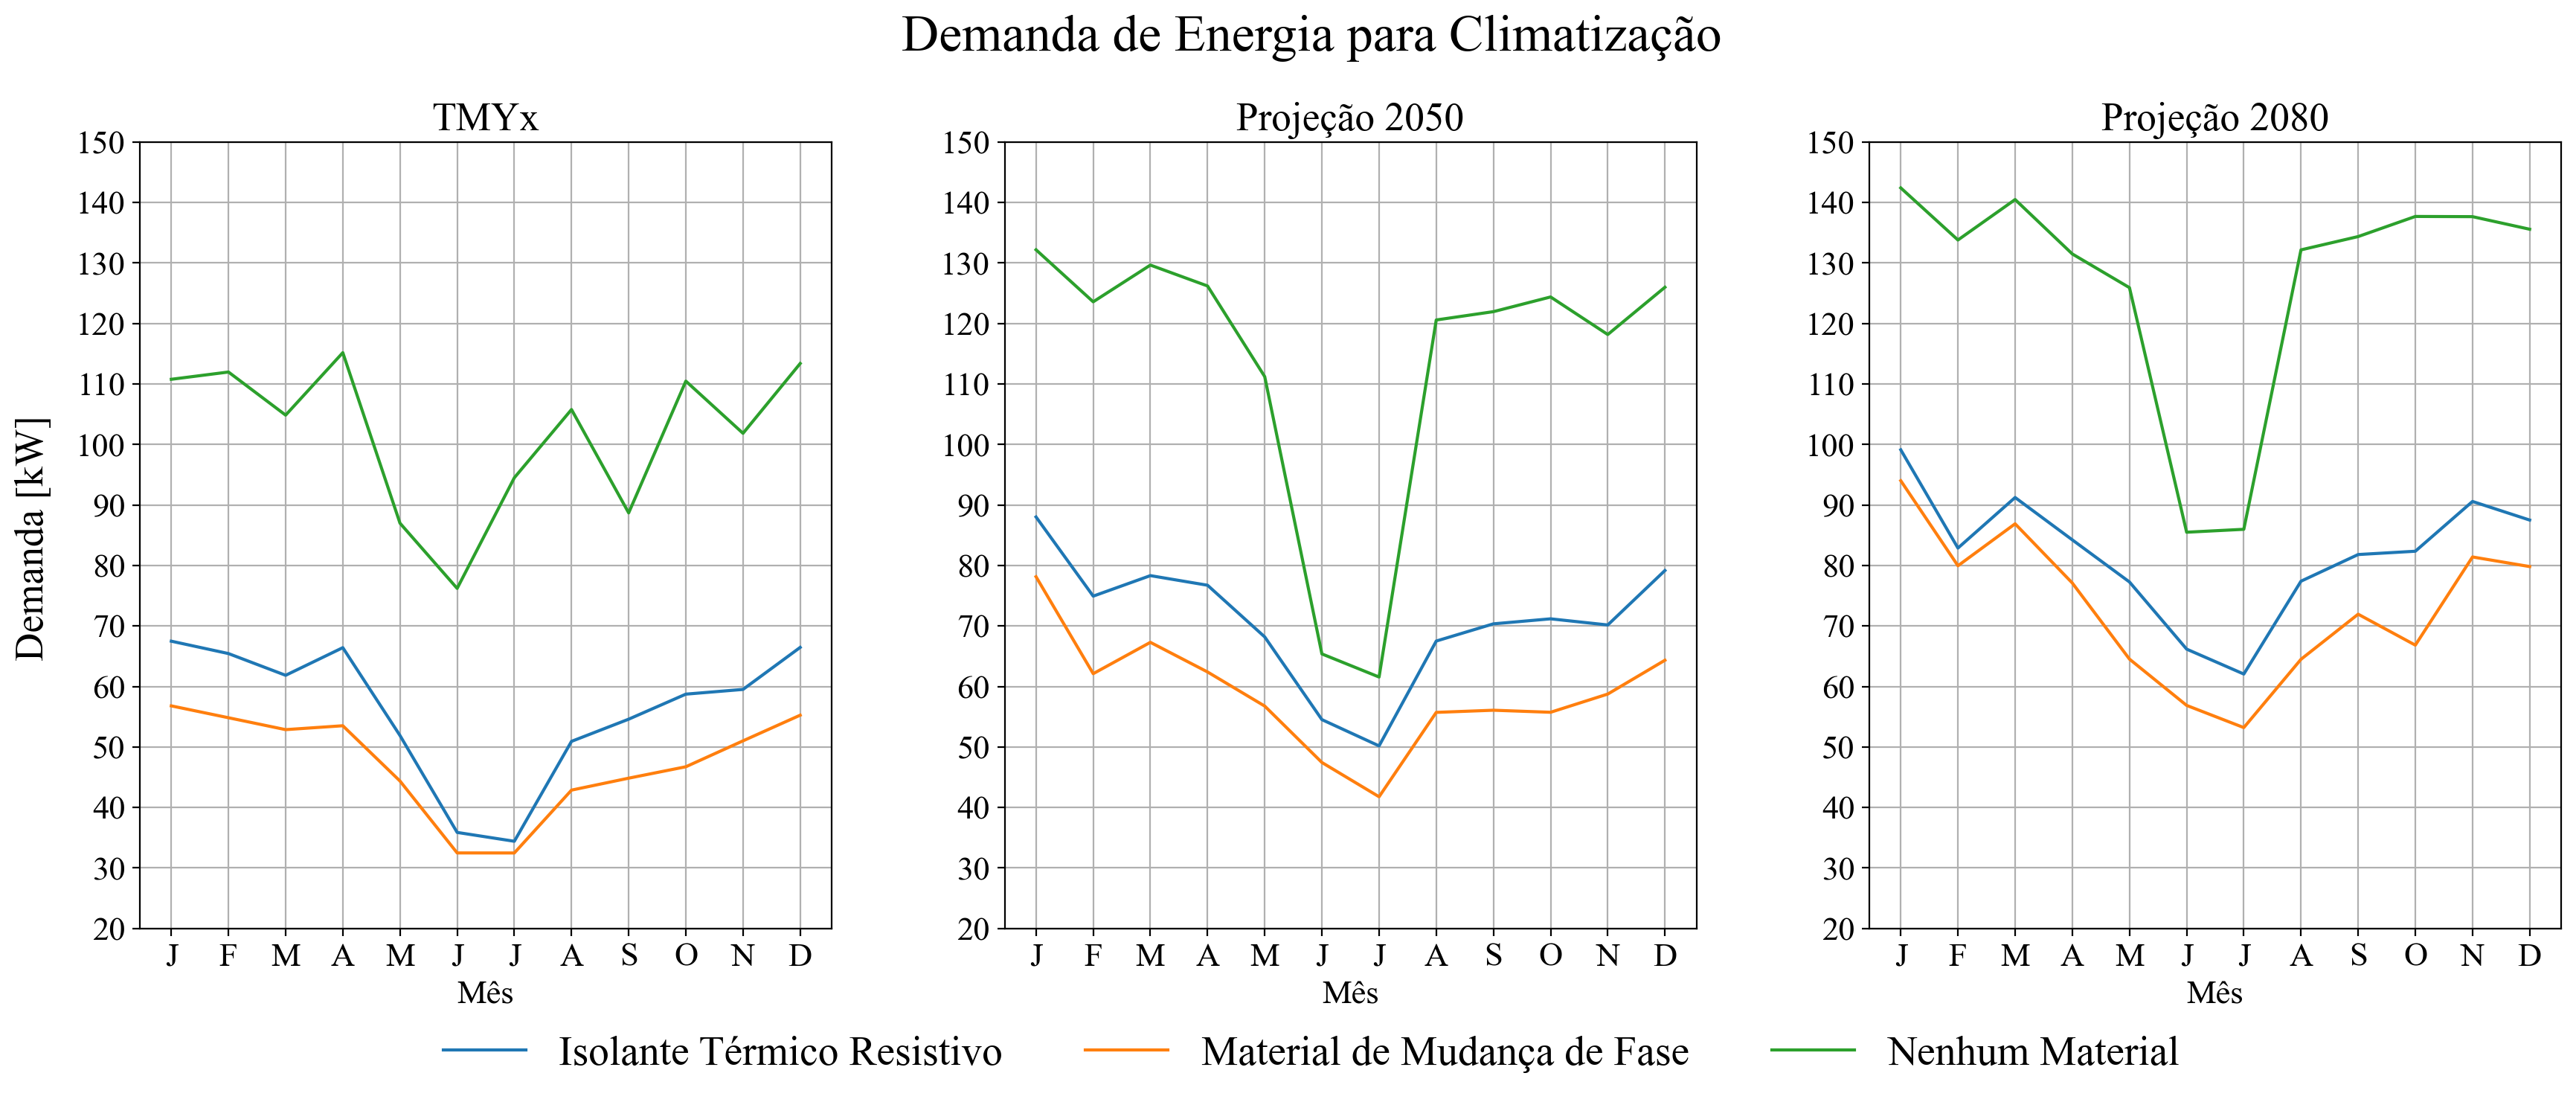

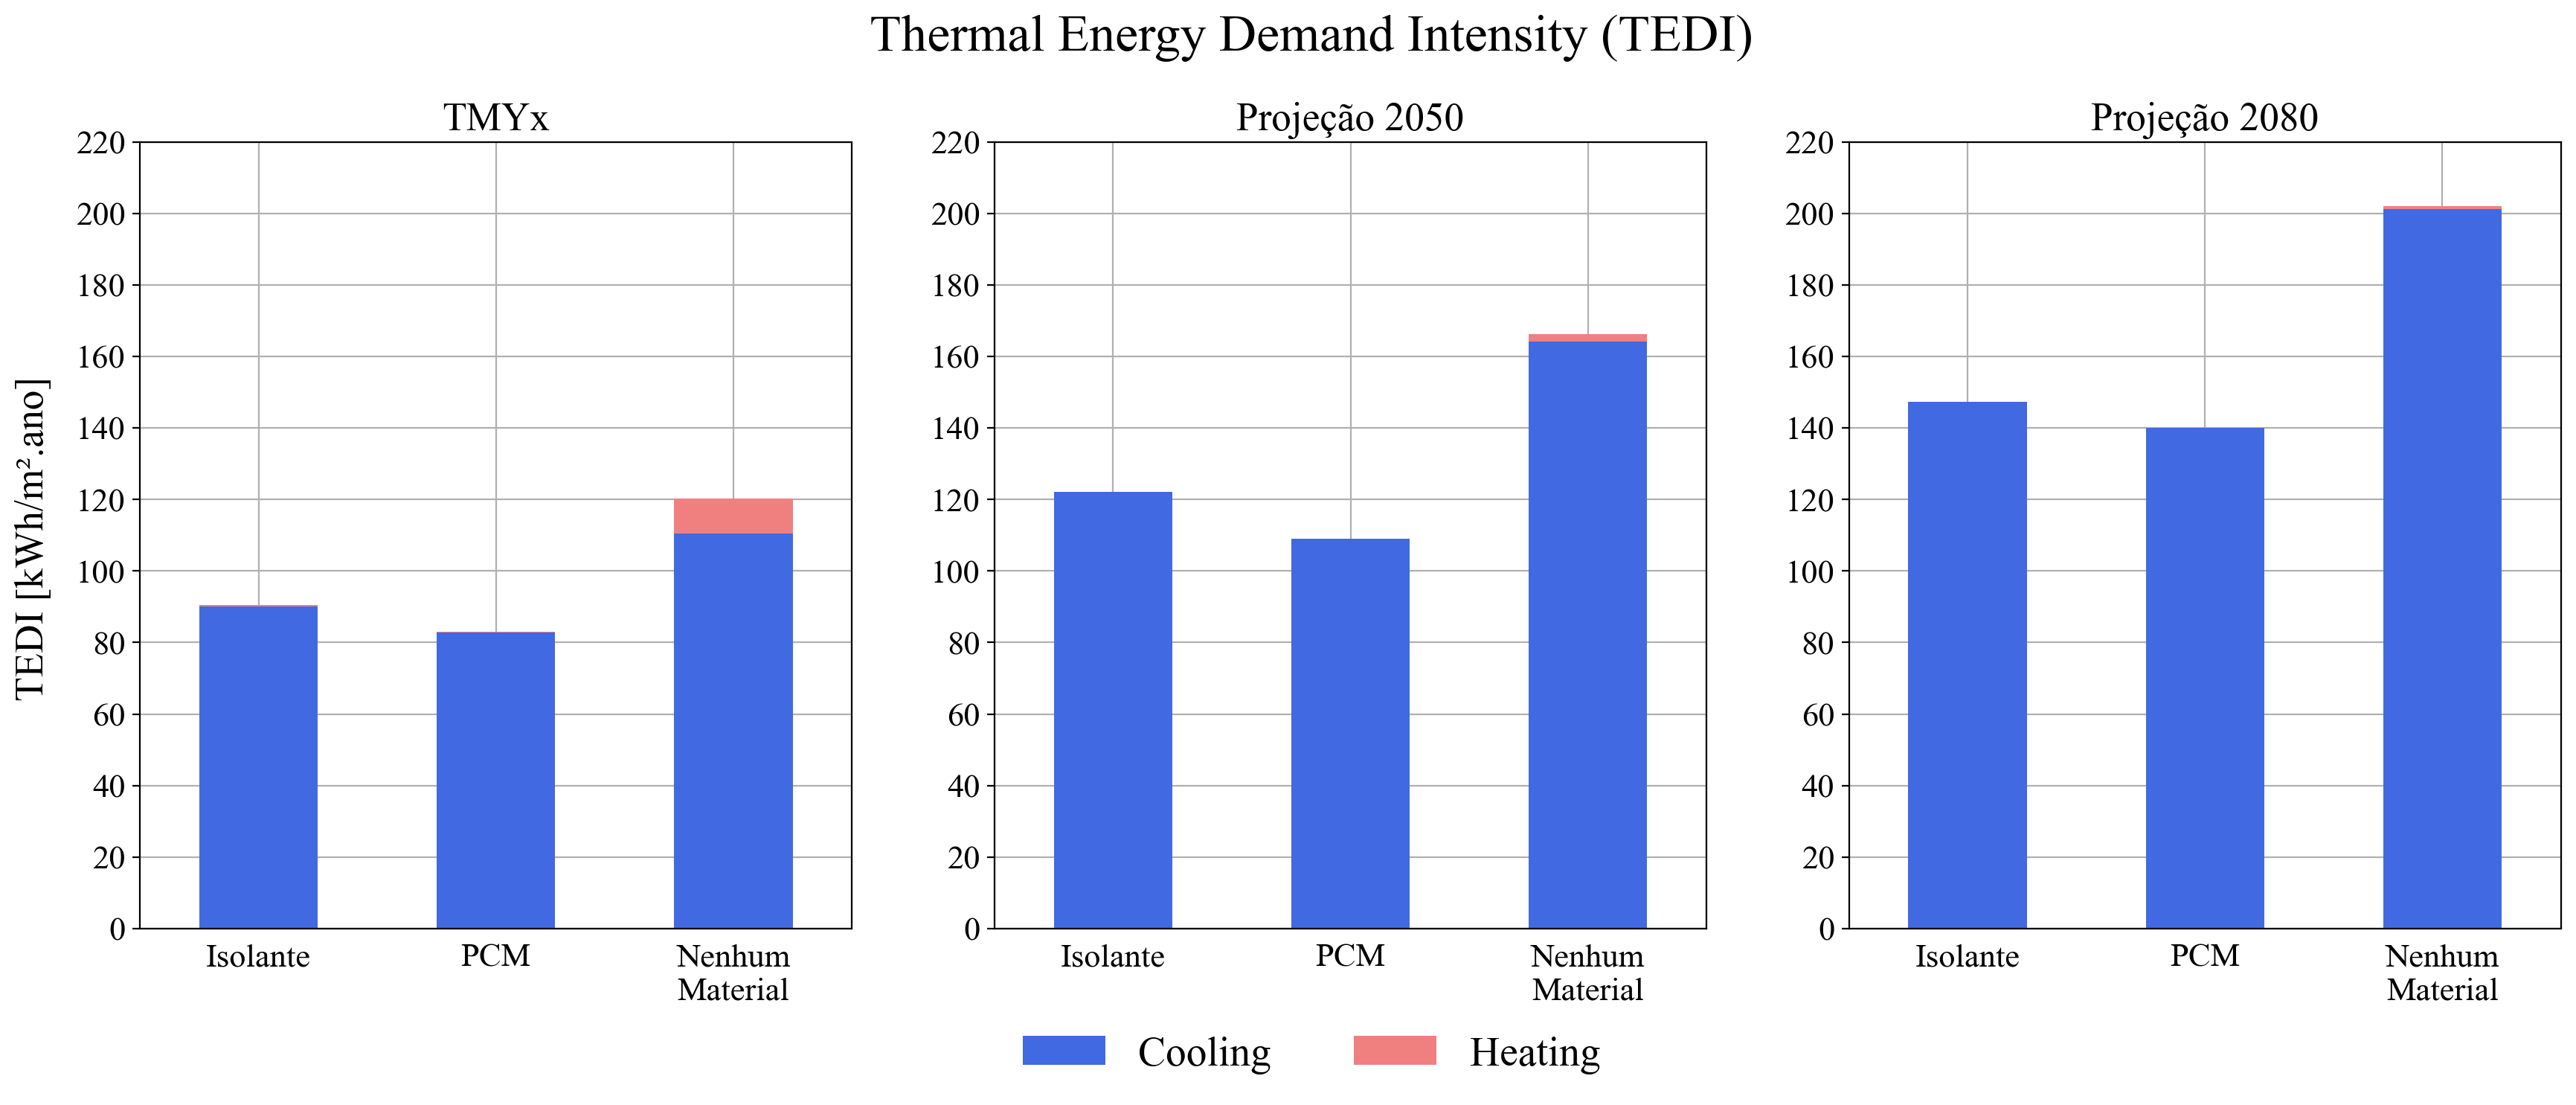

In [371]:
dft = comparar_consumo(consumos);

##### Gerando objetos de zonas (zona 1, zona 3 e plenum)

##### Plots

Média Anual
TMYx: 20.11 °C
Projeção 2050: 22.35 °C (+11.11 %)
Projeção 2080: 24.34 °C (+21.04 %)

Mínima Anual
TMYx: 6.85 °C
Projeção 2050: 8.85 °C (+29.21 %)
Projeção 2080: 11.35 °C (+65.72 %)

Máxima Anual
TMYx: 33.0 °C
Projeção 2050: 35.6 °C (+7.88 %)
Projeção 2080: 38.1 °C (+15.45 %)


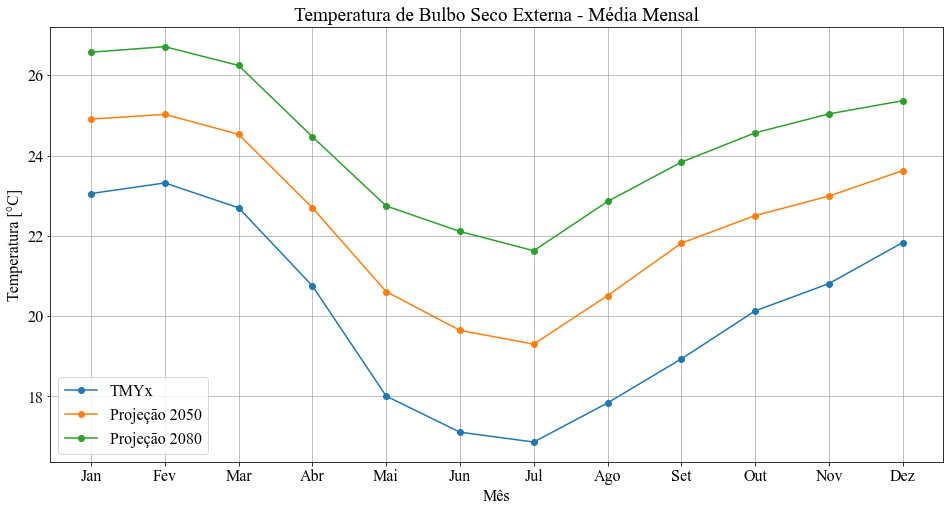

In [344]:
comparar_climas(climate_list=climas);

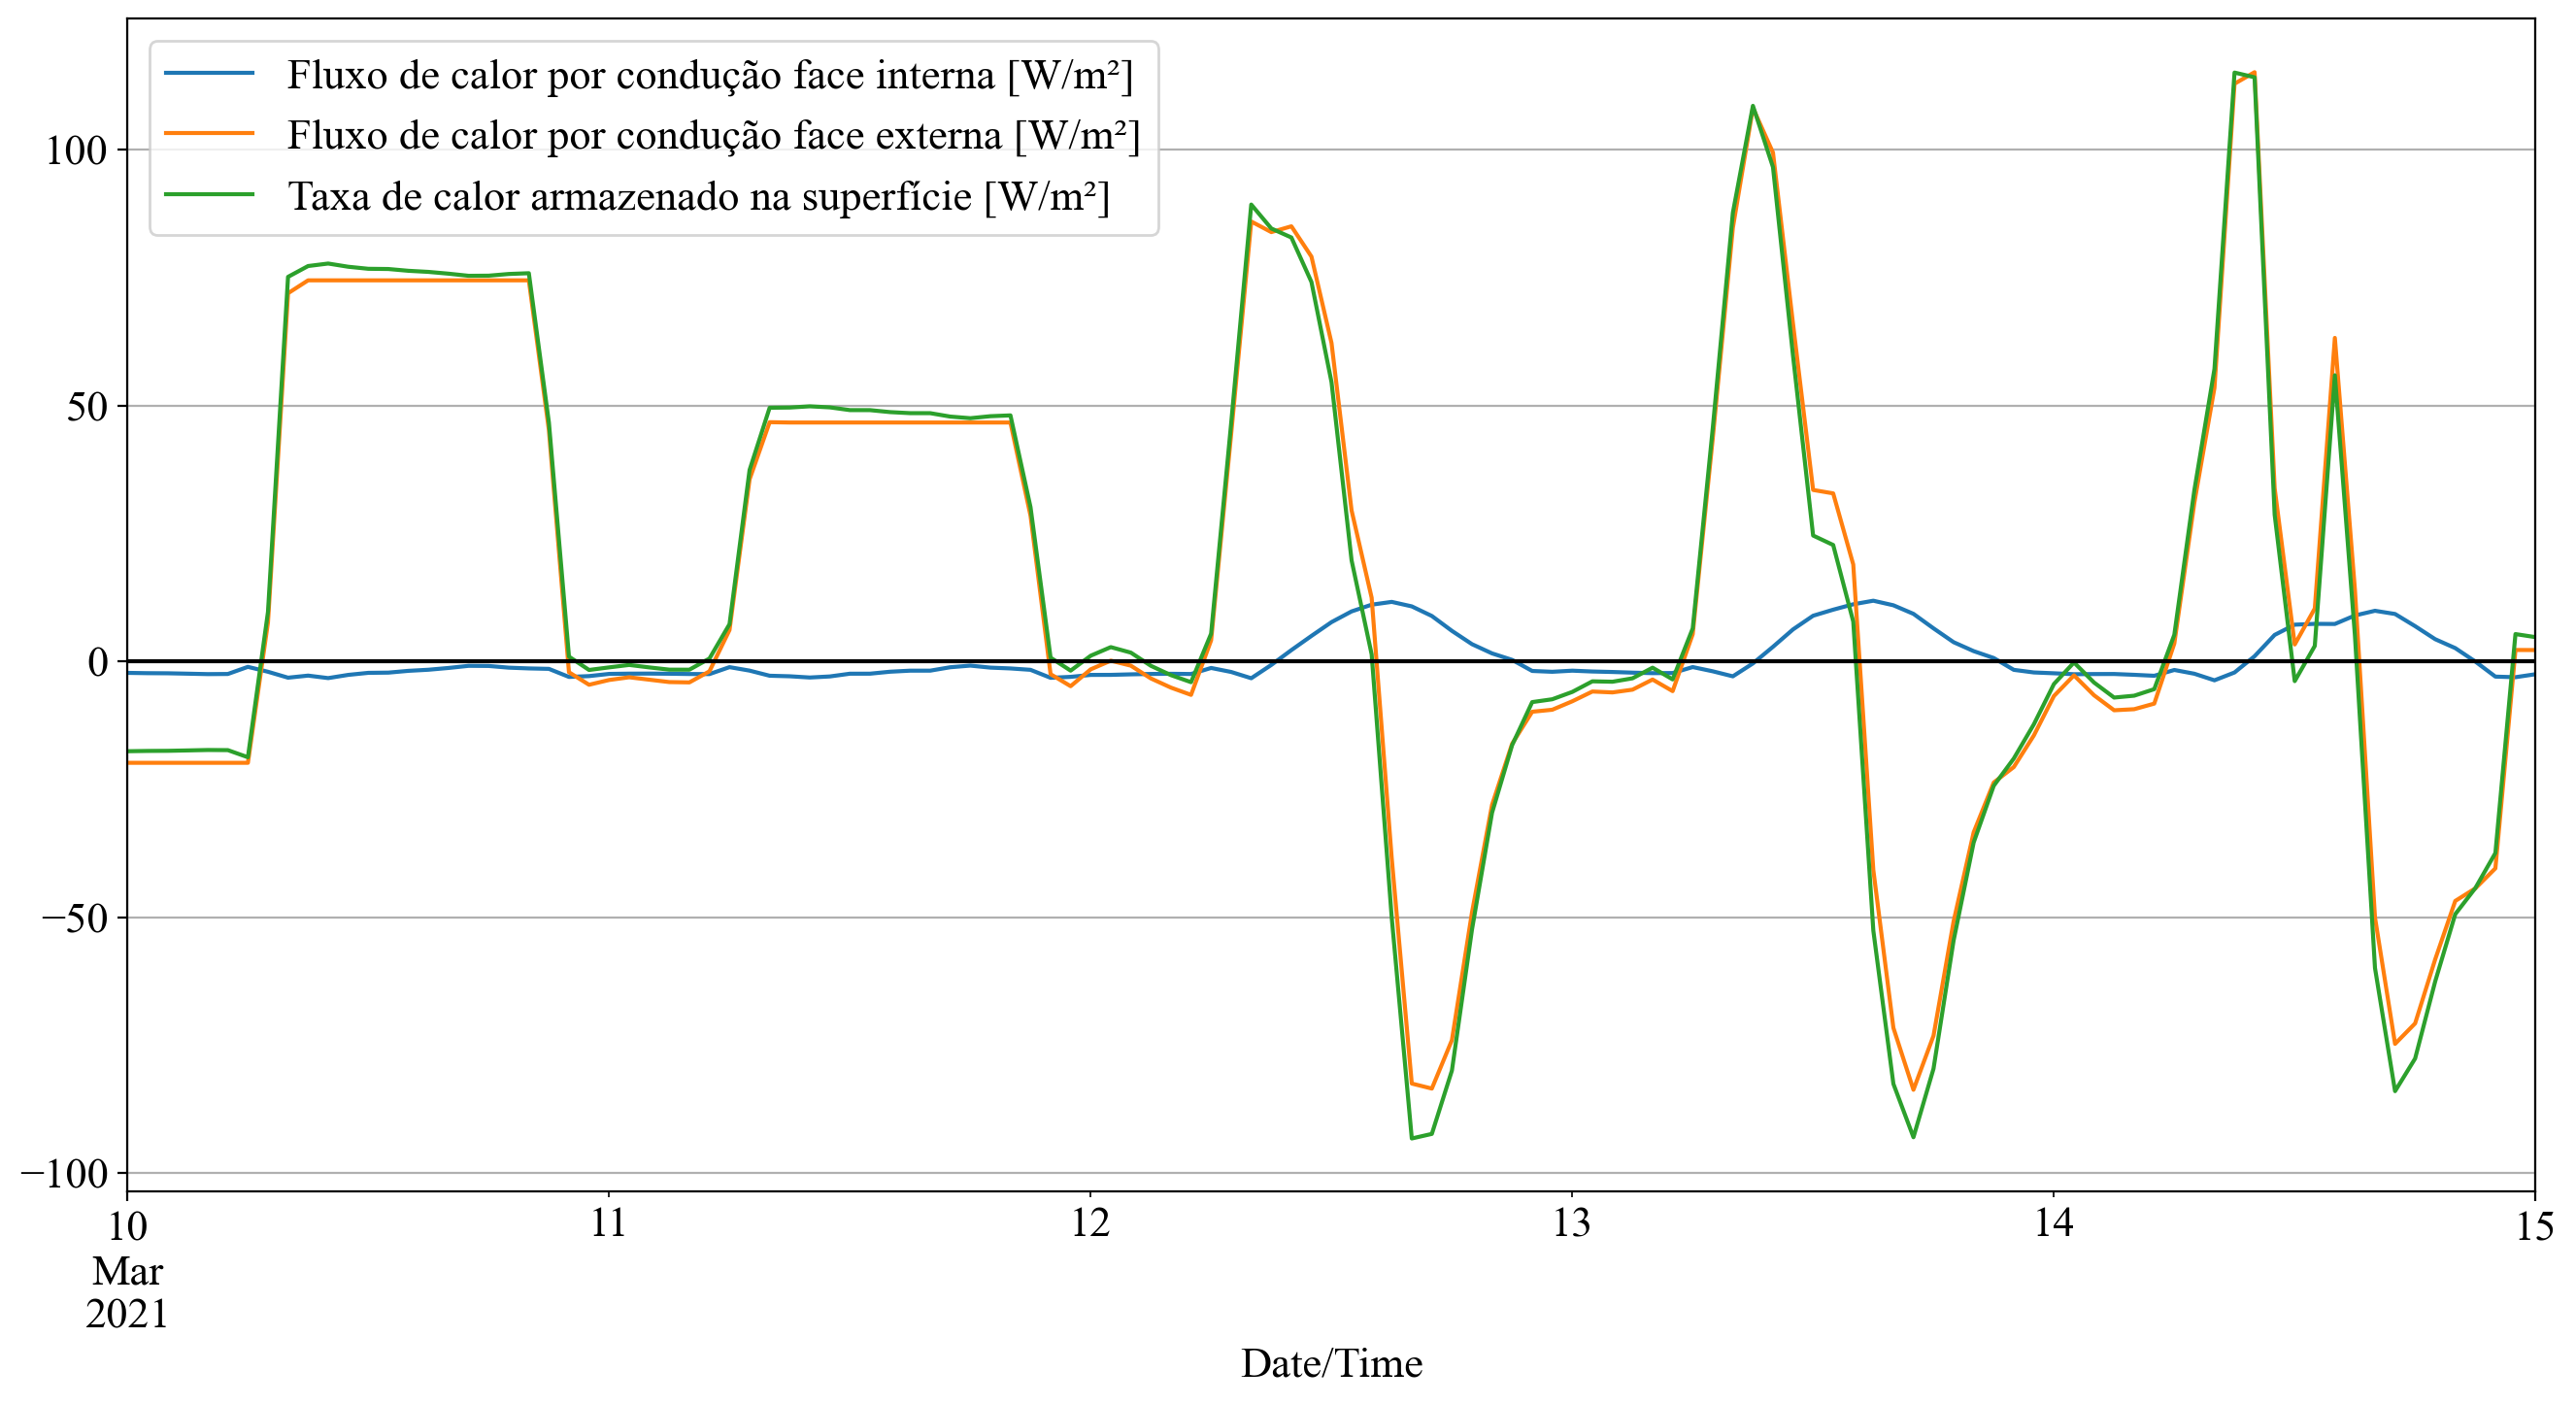

In [372]:
ax = zn3_iso2020[0].truncate(before = '2021-03-10', after = '2021-03-15').plot(y=['Fluxo de calor por condução face interna [W/m²]', 
                                                                             'Fluxo de calor por condução face externa [W/m²]',
                                                                             'Taxa de calor armazenado na superfície [W/m²]'], 
                                                                             grid = 'both', legend=True)
#ax = zn3_iso2020[0][].truncate(before = '2020-01-20', after = '2020-01-30').plot(secondary_y = True, grid = 'both', legend=True)
ax.axhline(0, color='black')
plt.show()

Opções: ['Fluxo de calor por condução face interna [W/m²]', 'Fluxo de calor por condução face externa [W/m²]', 'Taxa de calor armazenado na superfície [W/m²]', 'Temperatura da face interna [°C]', 'Temperatura da face externa [°C]', 'Temperatura Média Radiante [°C]', 'Temperatura Operativa [°C]', 'Fluxo de calor líquido por condução [W/m²]']


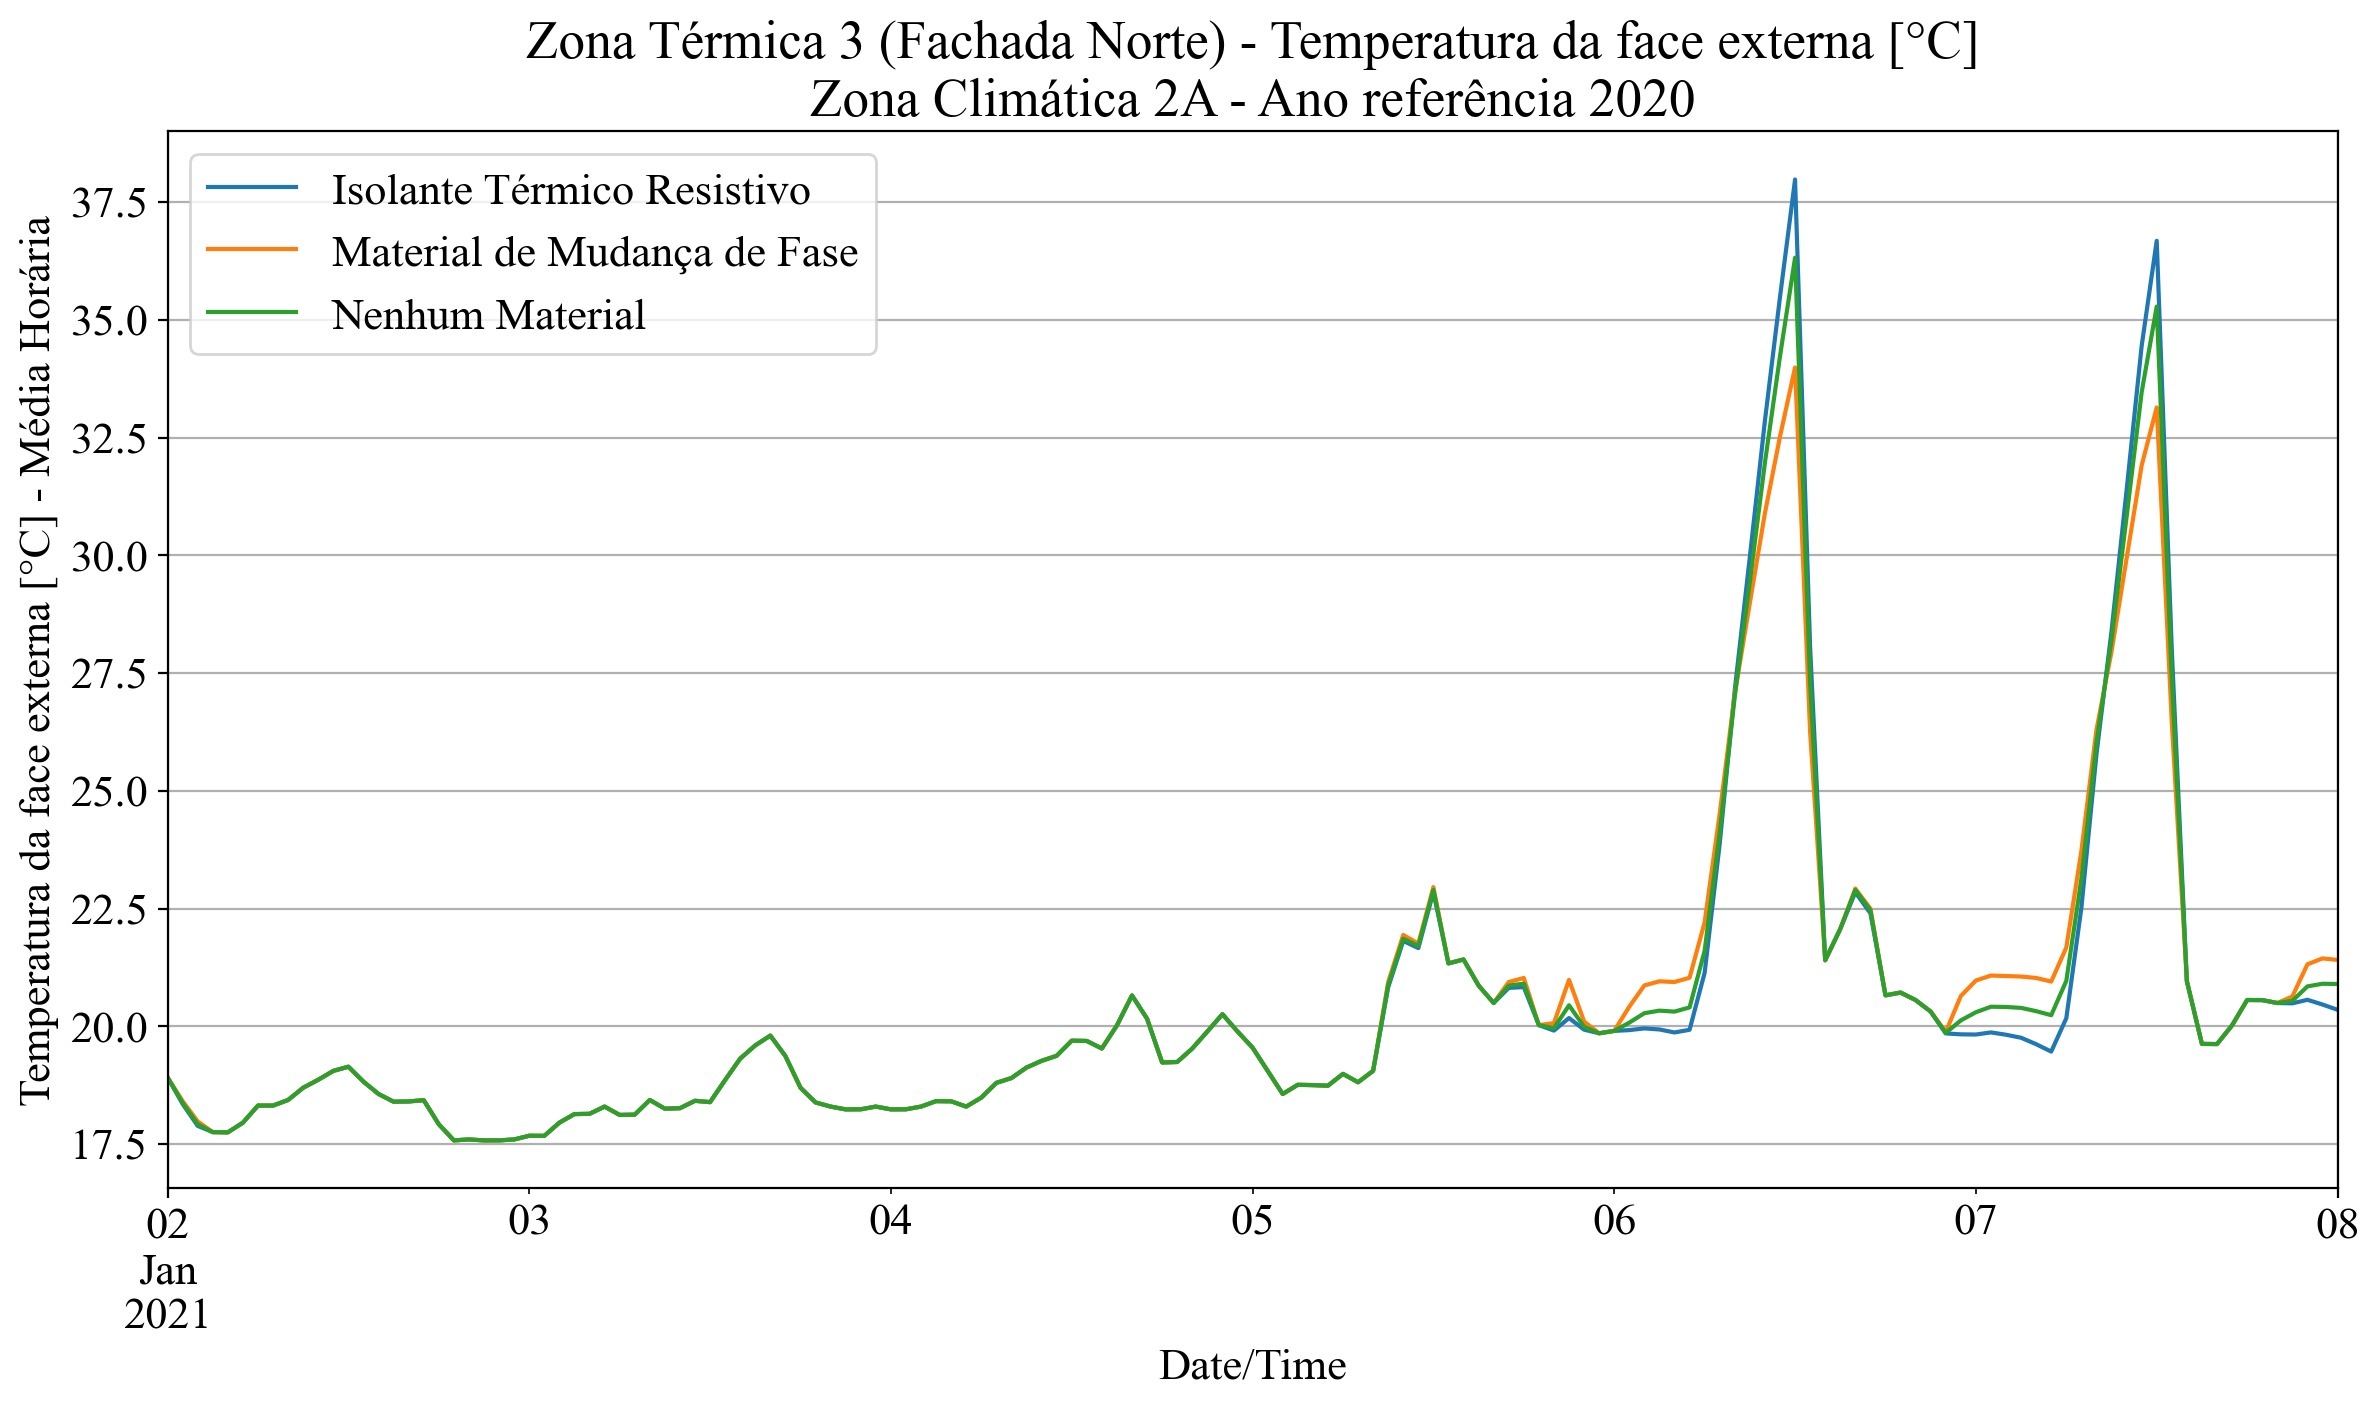

In [373]:
teste = comparar_casos(zone_list = zn3_2020, var1 = 'Temperatura da face externa [°C]', var2 = None,
                resample = True, how = 'H', trunc = True, before = '2021-01-02', after = '2021-01-08');

Opções: ['Fluxo de calor por condução face interna [W/m²]', 'Fluxo de calor por condução face externa [W/m²]', 'Temperatura da face interna [°C]', 'Temperatura da face externa [°C]', 'Temperatura Média Radiante [°C]', 'Temperatura Operativa [°C]', 'Fluxo de calor líquido [W/m²]']


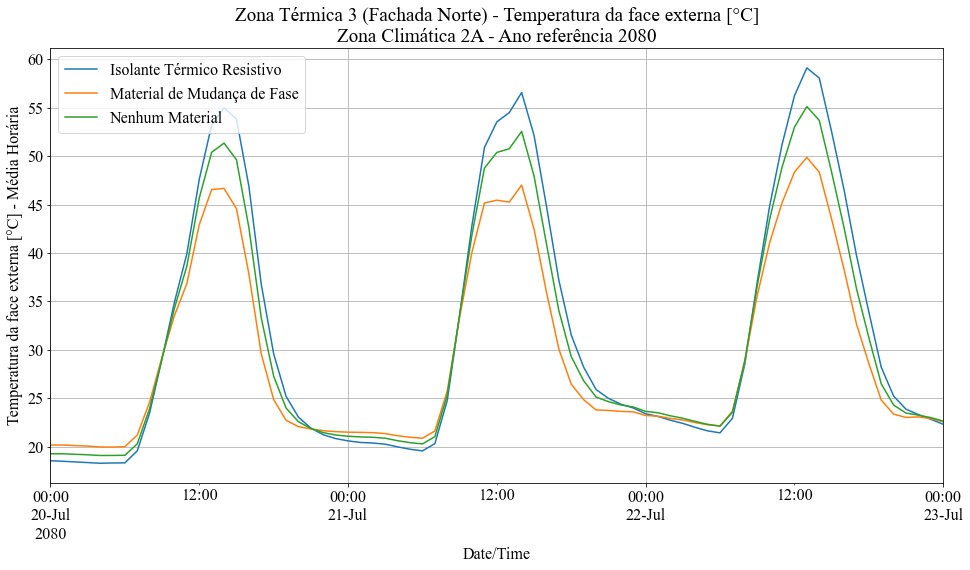

In [51]:
comparar_casos(zone_list = zn3_2080, var1 = 'Temperatura da face externa [°C]', 
                resample = True, how = 'H', trunc = True, before = '2080-07-20', after = '2080-07-23');

Opções: ['Fluxo de calor por condução face interna [W/m²]', 'Fluxo de calor por condução face externa [W/m²]', 'Temperatura da face interna [°C]', 'Temperatura da face externa [°C]', 'Temperatura Média Radiante [°C]', 'Temperatura Operativa [°C]']


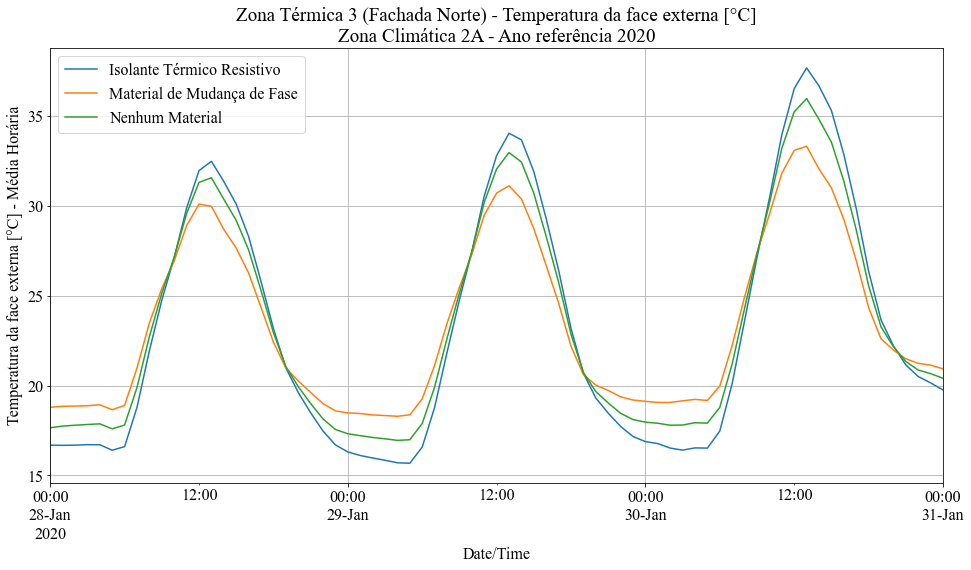

In [188]:
comparar_casos(zone_list = zn3_2020, var1 = 'Temperatura da face externa [°C]', 
                resample = True, how = 'H', trunc = True, before = '2020-01-28', after = '2020-01-31');

Opções: ['Temperatura Média Radiante [°C]', 'Temperatura Operativa [°C]', 'Fluxo de calor por condução face interna [W/m²]', 'Fluxo de calor por condução face externa [W/m²]', 'Temperatura da face interna [°C]', 'Temperatura da face externa [°C]']


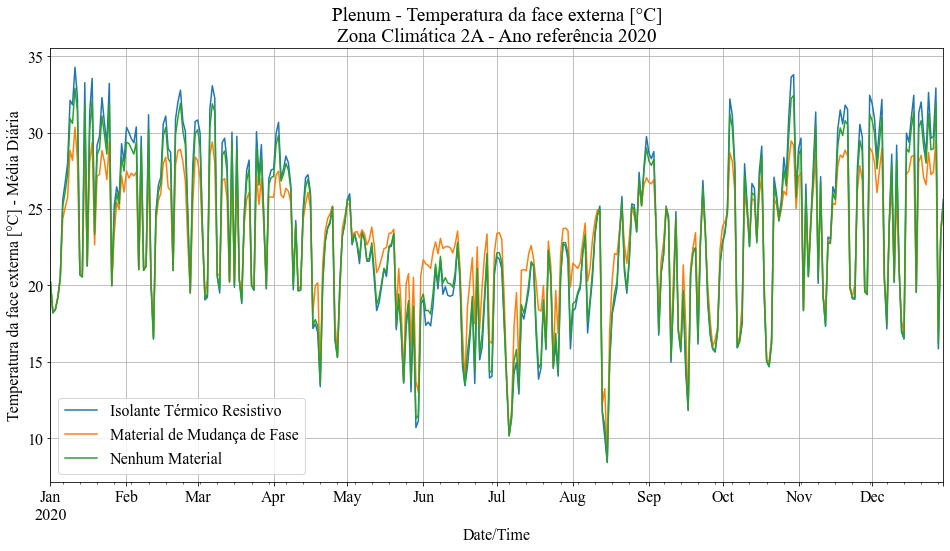

In [16]:
comparar_casos(zone_list = plenum_2020, var1 = 'Temperatura da face externa [°C]', 
                resample = True, how = 'D', trunc = False, before = '2020-04-20', after = '2020-04-30');

### Plots

2A-PCM-2020


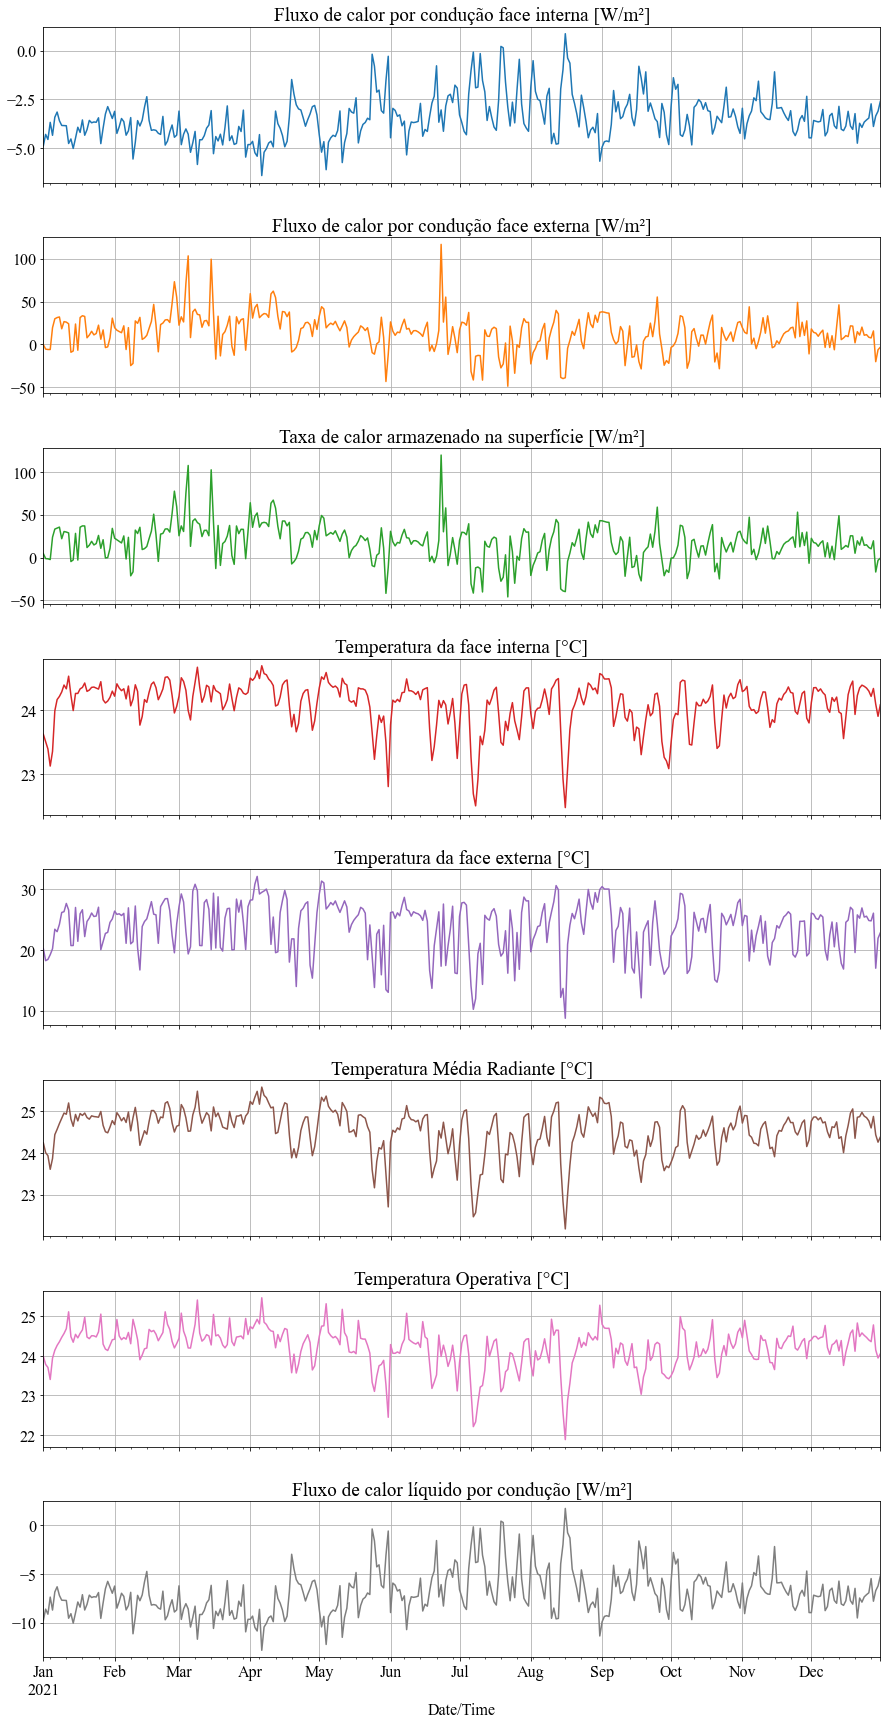

In [346]:
plotar_zona(zn3_pcm2020)

### Testes epw

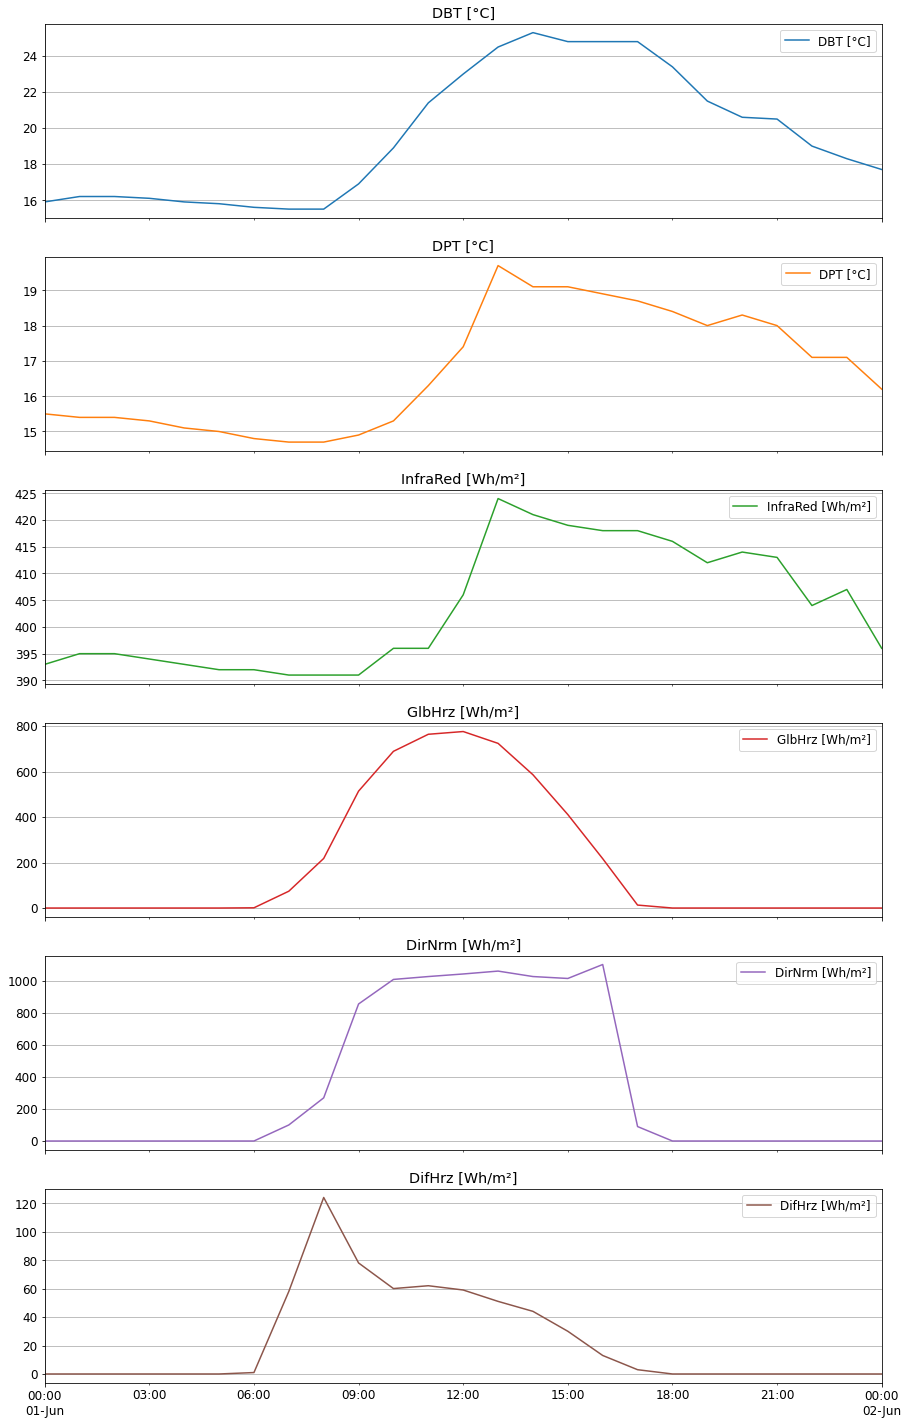

In [224]:
sp2020 = climate('climaticos/BRA_Sao Paulo-Congonhas AP_HadCM3-A2-2020.csv', 2020)

axes = sp2020.df.truncate(before='2020-06-01', after='2020-06-02').plot(figsize=(15,25), 
                    subplots=True, grid = 'both');

for plots in axes:
    plots.set_title(sp2020.df.columns[list(axes).index(plots)])

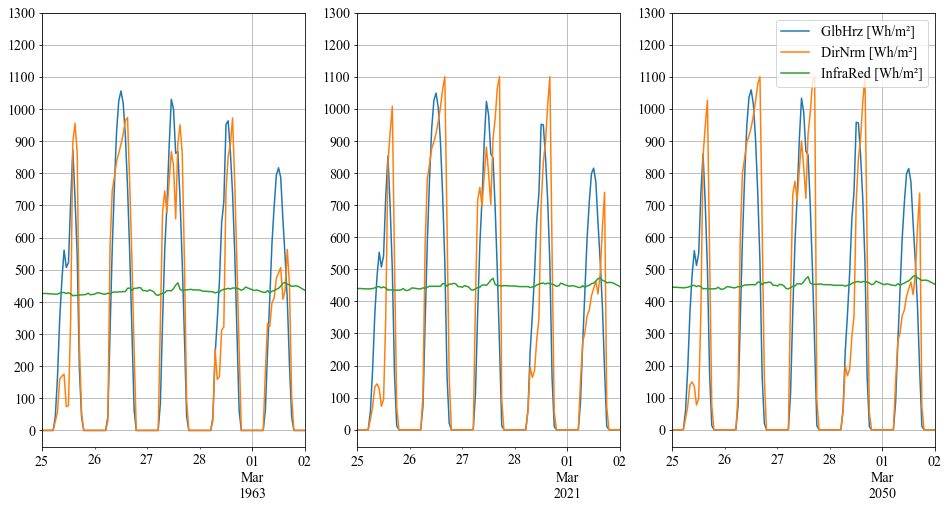

In [45]:
rj2020 = climate('climaticos\Rio-de-Janeiro-2020.csv', 2021)
rj2050 = climate('climaticos\Rio-de-Janeiro-2050.csv', 2050)
rj1963 = climate('climaticos/BRA_RJ_Rio.de.Janeiro-Galeao-Jobim.Intl.AP.837460_TRY.1963.csv', 1963)

data20 = rj2020.df.truncate(before='2021-02-25', after='2021-03-02')
data50 = rj2050.df.truncate(before='2050-02-25', after='2050-03-02')
data63 = rj1963.df.truncate(before='1963-02-25', after='1963-03-02')

fig, (ax, ax2, ax3) = plt.subplots(ncols = 3)

data20.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax2, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)
data50.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax3, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)
data63.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax, 
           figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)

plt.legend(['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'])
plt.show()

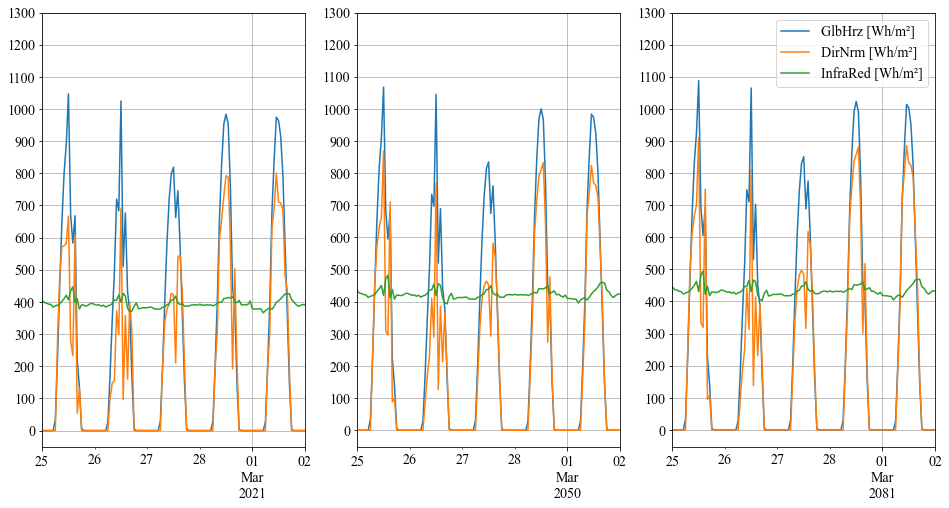

In [10]:
sp2020_tmyx = climate('climaticos/TMYx/BRA_SP_Sao.Paulo-Congonhas.AP.837800_TMYx.csv', 2021)
sp2050 = climate('climaticos/TMYx/BRA_Sao Paulo Congonhas AP_HadCM3-A2-2050.csv', 2050)
sp2080 = climate('climaticos/TMYx/BRA_Sao Paulo Congonhas AP_HadCM3-A2-2080.csv', 2081)

tmyx = sp2020_tmyx.df.truncate(before='2021-02-25', after='2021-03-02')
data50 = sp2050.df.truncate(before='2050-02-25', after='2050-03-02')
data80 = sp2080.df.truncate(before='2081-02-25', after='2081-03-02')

fig, (ax, ax2, ax3) = plt.subplots(ncols = 3)

tmyx.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)
data50.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax2, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)
data80.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax3, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)

plt.legend(['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'])
plt.show()

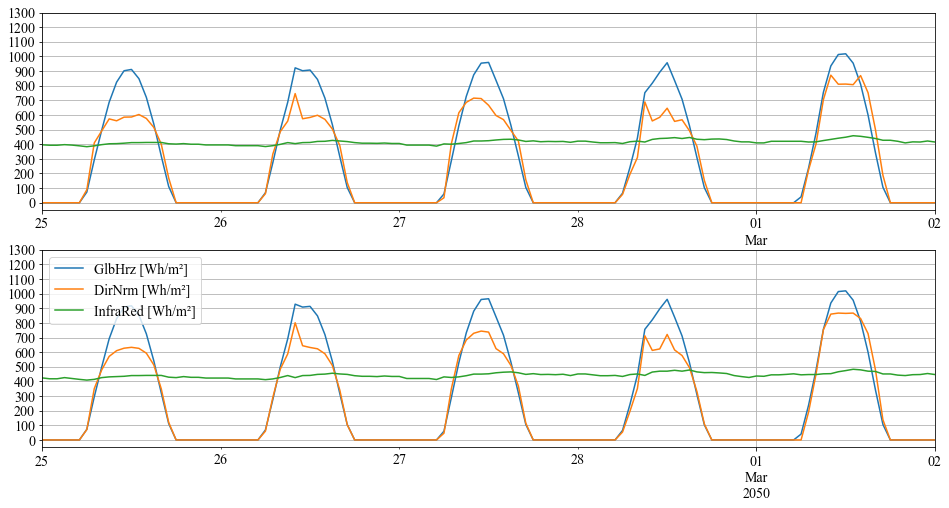

In [49]:
rj2020_tmyx = climate('climaticos\TMYx\RJ\BRA_RJ_Rio.de.Janeiro-Santos.Dumont.AP.837550_TMYx.csv', 2021)
rj2050_tmyx = climate('climaticos\TMYx\RJ\BRA_Rio de Janeiro Santos Dumont AP_HadCM3-A2-2050.csv', 2050)

data20_tmyx = rj2020_tmyx.df.truncate(before='2021-02-25', after='2021-03-25')
data50_tmyx = rj2050_tmyx.df.truncate(before='2050-02-25', after='2050-03-25')

fig, (ax, ax2) = plt.subplots(2)

data20_tmyx.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)
data50_tmyx.plot(y = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'], ax=ax2, 
            figsize=(16,8), yticks = np.arange(0,1400,100), grid = 'both', legend=False)

plt.legend(['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]'])
plt.show()

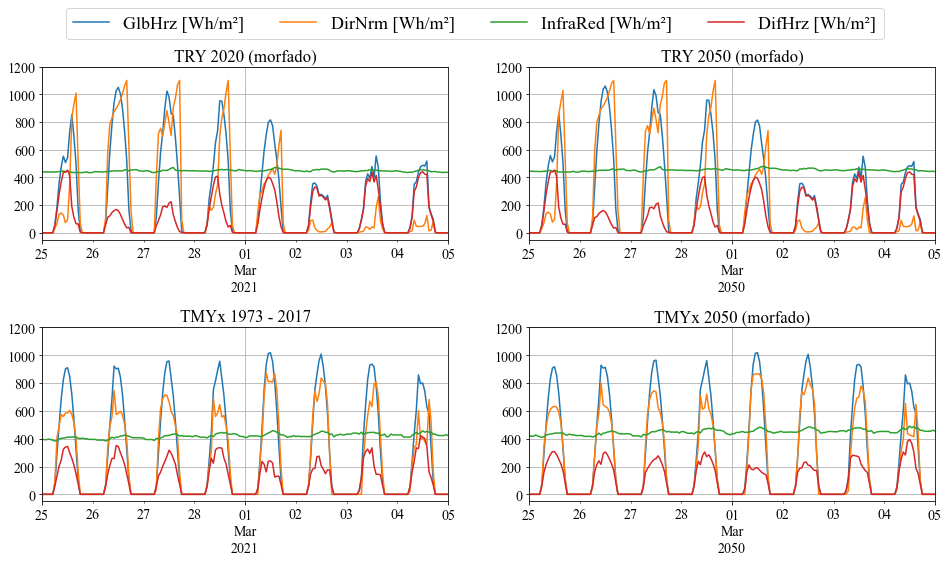

In [60]:
data20 = rj2020.df.truncate(before='2021-02-25', after='2021-03-05')
data50 = rj2050.df.truncate(before='2050-02-25', after='2050-03-05')
data20_tmyx = rj2020_tmyx.df.truncate(before='2021-02-25', after='2021-03-05')
data50_tmyx = rj2050_tmyx.df.truncate(before='2050-02-25', after='2050-03-05')

labels = ['GlbHrz [Wh/m²]', 'DirNrm [Wh/m²]', 'InfraRed [Wh/m²]', 'DifHrz [Wh/m²]']

fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16,8))

data20.plot(y = labels, ax=ax, 
            yticks = np.arange(0,1400,200), grid = 'both', legend=False)
ax.set_title('TRY 2020 (morfado)')

data50.plot(y = labels, ax=ax2, 
            yticks = np.arange(0,1400,200), grid = 'both', legend=False)
ax2.set_title('TRY 2050 (morfado)')

data20_tmyx.plot(y = labels, ax=ax3, 
            yticks = np.arange(0,1400,200), grid = 'both', legend=False)
ax3.set_title('TMYx 1973 - 2017')

data50_tmyx.plot(y = labels, ax=ax4, 
            yticks = np.arange(0,1400,200), grid = 'both', legend=False)
ax4.set_title('TMYx 2050 (morfado)')

plt.subplots_adjust(hspace=0.5)
fig.legend(labels, loc='upper center', ncol=len(labels), fontsize=18);